In [2]:
import torchvision
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

dataset_voc = torchvision.datasets.VOCSegmentation(
    "./data/pascal_voc/",
    year="2012",
    download=True,
    image_set="val",
)
print("number of images in the dataset:", len(dataset_voc))

100%|███████████████████████████████| 1999639040/1999639040 [08:41<00:00, 3836647.60it/s]


Extracting ./data/pascal_voc/VOCtrainval_11-May-2012.tar to ./data/pascal_voc/
number of images in the dataset: 1449


In [3]:
from einops import rearrange
import torch
from PIL import Image
import torchvision.transforms as transforms
from torch import nn
import numpy as np


def feature_extractor(images, resolution=(448, 448), layer=11):
    if isinstance(images, list):
        assert isinstance(images[0], Image.Image), "Input must be a list of PIL images."
    else:
        assert isinstance(images, Image.Image), "Input must be a PIL image."
        images = [images]

    transform = transforms.Compose(
        [
            transforms.Resize(resolution),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    # extract DINOv2 last layer features from the image
    class DiNOv2Feature(torch.nn.Module):
        def __init__(self, ver="dinov2_vitb14_reg", layer=11):
            super().__init__()
            self.dinov2 = torch.hub.load("facebookresearch/dinov2", ver)
            self.dinov2.requires_grad_(False)
            self.dinov2.eval()
            self.dinov2 = self.dinov2.cuda()
            self.layer = layer

        def forward(self, x):
            out = self.dinov2.get_intermediate_layers(x, reshape=True, n=np.arange(12))[self.layer]
            return out

    feat_extractor = DiNOv2Feature(layer=layer)

    feats = []
    for i, image in enumerate(images):
        torch_image = transform(image)
        feat = feat_extractor(torch_image.unsqueeze(0).cuda()).cpu()
        feat = feat.squeeze(0).permute(1, 2, 0)
        feats.append(feat)
    feats = torch.stack(feats).squeeze(0)
    return feats



In [4]:
image = dataset_voc[0][0]
feat = feature_extractor(image, resolution=(448, 448), layer=9)
print("Feature shape per-image:", feat.shape)
num_nodes = feat.shape[0] * feat.shape[1]
print("Number of nodes per-image:", num_nodes)

Using cache found in /home/andrew/.cache/torch/hub/facebookresearch_dinov2_main
/home/andrew/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/andrew/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/andrew/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Feature shape per-image: torch.Size([32, 32, 768])
Number of nodes per-image: 1024


In [5]:
# create a large-scale feature matrix
images = [dataset_voc[i][0] for i in range(100)]
feats = feature_extractor(images, resolution=(448, 448), layer=9)
print("Feature shape for 100 images:", feats.shape)
num_nodes = np.prod(feats.shape[:3])
print("Number of nodes for 100 images:", num_nodes)

Using cache found in /home/andrew/.cache/torch/hub/facebookresearch_dinov2_main


Feature shape for 100 images: torch.Size([100, 32, 32, 768])
Number of nodes for 100 images: 102400


In [6]:
import sys, os
sys.path.append(os.path.join(os.path.dirname(sys.path[0]), 'ncut_pytorch'))
from ncut_pytorch import NCUT
import time

input_feats = feats.reshape(num_nodes, -1)

start = time.time()
eigenvectors, eigenvalues = NCUT(
    num_eig=50, num_sample=30000, knn=10, affinity_focal_gamma=0.3, device='cpu'
).fit_transform(input_feats)
end = time.time()
print("Nyström ncut time: {:.3f}".format(end - start))

Nyström ncut time: 20.777


In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d(X_3d, rgb, title):

    rand_indices = np.random.choice(num_nodes, 10000)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={"projection": "3d"})
    # plot 3 views of the 3D t-SNE, scatter plot, color by RGB
    # use 3D axes to show the 3D t-SNE
    for i, ax in enumerate(axs):
        ax.scatter(*X_3d[rand_indices].T, c=rgb[rand_indices], s=1)
        ax.view_init(elev=30, azim=45 * i)
        ax.set_title(f"View {i}")
    plt.suptitle(title)
    plt.show()

def plot_images(images, rgb, title):
    fig, axs = plt.subplots(6, 8, figsize=(10, 6))
    for i_row in range(0, 6, 2):
        for i_col in range(8):
            ax = axs[i_row, i_col]
            image = images[i_row * 8 + i_col]
            image = image.resize((224, 224), Image.BILINEAR)
            ax.imshow(image)
            ax.axis("off")
        for i_col in range(8):
            ax = axs[i_row + 1, i_col]
            ax.imshow(rgb[i_row * 8 + i_col])
            ax.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()    

In [8]:
# apply umap for visualization of the eigenvectors
from ncut_pytorch import rgb_from_umap_sphere

start = time.time()
X_3d, rgb = rgb_from_umap_sphere(
    eigenvectors[:, :50],
    num_sample=30000,
    n_neighbors=100,
    min_dist=0.1,
    metric="euclidean",
    device='cpu',
)
end = time.time()
print("UMAP time: {:.3f}".format(end - start))

/home/andrew/miniconda3/envs/ofa/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP time: 119.629


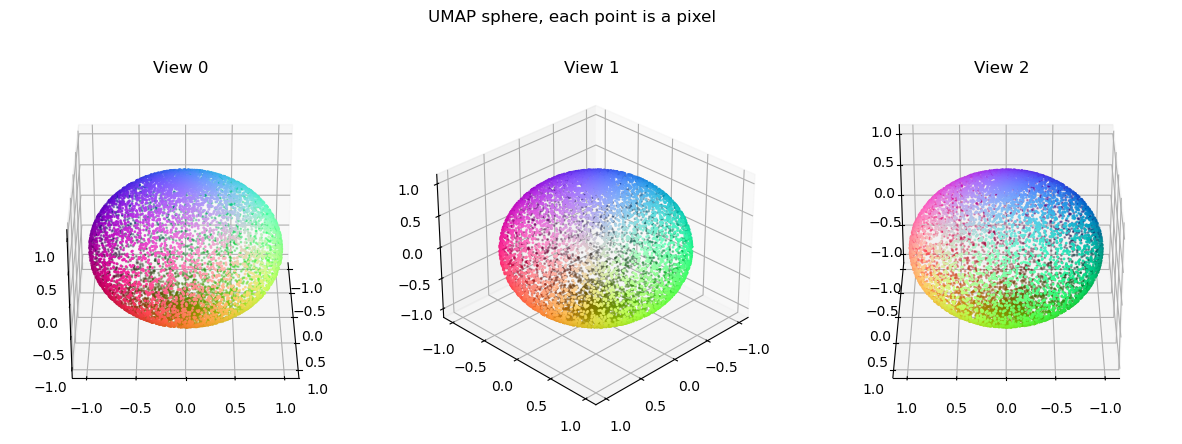

In [9]:
# visualize the 3D UMAP sphere in 3D
plot_3d(X_3d, rgb, "UMAP sphere, each point is a pixel")

In [10]:
# visualize the 3D UMAP sphere in 2D
from ncut_pytorch import flatten_sphere
X_2d = flatten_sphere(X_3d)

rand_indices = np.random.choice(num_nodes, 10000)
plt.scatter(*X_2d[rand_indices].T, c=rgb[rand_indices], s=1)
plt.title("sphere spectral-UMAP, each point is a pixel")
plt.show()

ImportError: cannot import name 'flatten_sphere' from 'ncut_pytorch' (/home/andrew/codebases/ncut_pytorch/ncut_pytorch/ncut_pytorch/__init__.py)

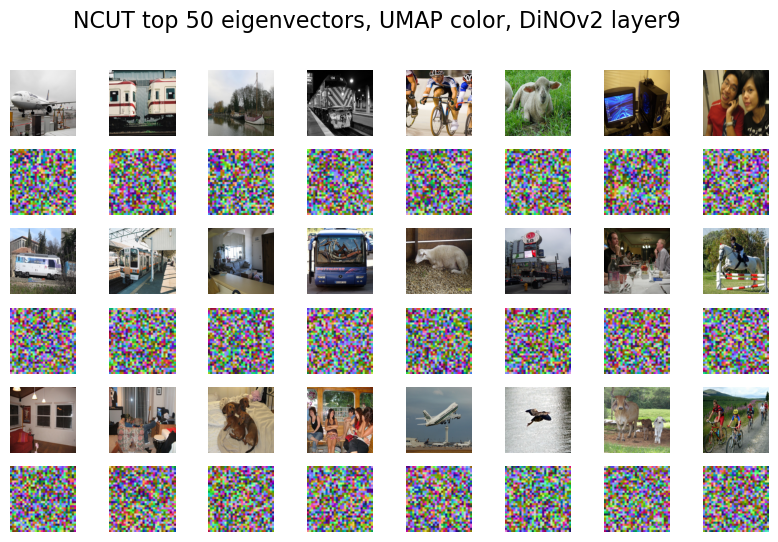

In [11]:
image_rgb = rgb.reshape(feats.shape[:3] + (3,))
plot_images(images, image_rgb, "NCUT top 50 eigenvectors, UMAP color, DiNOv2 layer9")

t-SNE time: 821.864


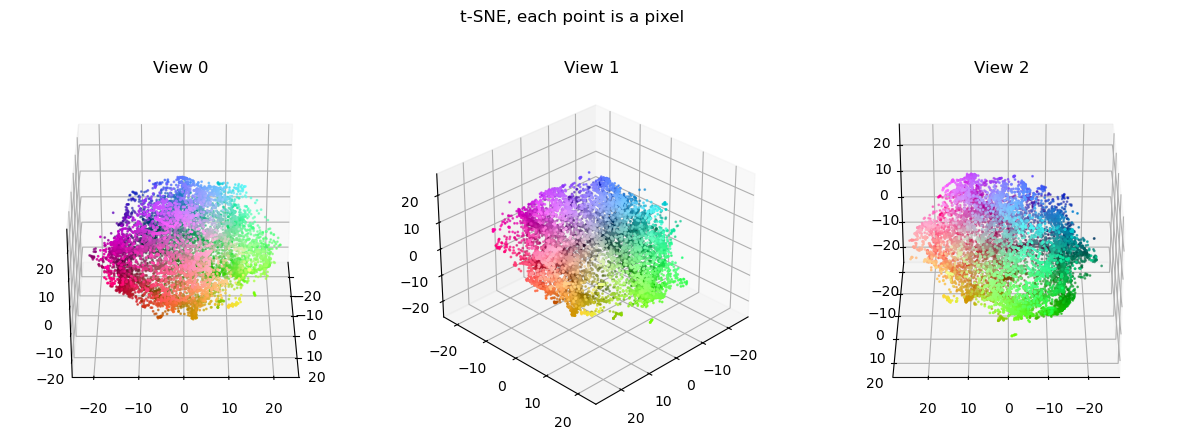

In [12]:
# apply t-SNE for visualization of the eigenvectors
from ncut_pytorch import rgb_from_tsne_3d
import time

start = time.time()
X_3d, rgb = rgb_from_tsne_3d(eigenvectors[:, :50], num_sample=30000, perplexity=100, device='cpu')
end = time.time()
print("t-SNE time: {:.3f}".format(end - start))

plot_3d(X_3d, rgb, "t-SNE, each point is a pixel")
image_rgb = rgb.reshape(feats.shape[:3] + (3,))

<ipython-input-5-0e4644bb7624>:25: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  image = image.resize((224, 224), Image.BILINEAR)


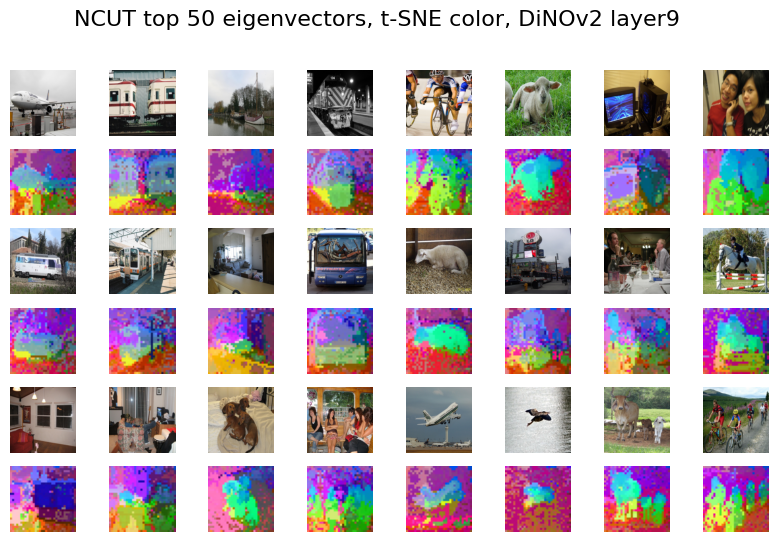

In [ ]:
plot_images(images, image_rgb, "NCUT top 50 eigenvectors, t-SNE color, DiNOv2 layer9")